In [1]:
pip install imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25855 sha256=6cd184bb363fe14c7056855b7cf0e9f7b08a5ac532460b02804d4b077b02ef2d
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\85\cf\3a\e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
DIRECTORY = 'dataset/'
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


c:\Coding\Machine_Learning\Code_Practice\venv\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# perform encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\HP\AppData\Local\Temp\ipykernel_27420\4269477345.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
from tensorflow.keras.optimizers import Adam

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)  # Use learning_rate instead of lr
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/20


c:\Coding\Machine_Learning\Code_Practice\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 64s 596ms/step - accuracy: 0.7279 - loss: 0.5706 - val_accuracy: 0.9791 - val_loss: 0.1540
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1917   
Epoch 3/20


c:\Coding\Machine_Learning\Code_Practice\venv\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


95/95 ━━━━━━━━━━━━━━━━━━━━ 55s 561ms/step - accuracy: 0.9651 - loss: 0.1616 - val_accuracy: 0.9870 - val_loss: 0.0786
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.9375 - loss: 0.1066 
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 712ms/step - accuracy: 0.9671 - loss: 0.1090 - val_accuracy: 0.9909 - val_loss: 0.0556
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.9688 - loss: 0.1393 
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 72s 751ms/step - accuracy: 0.9782 - loss: 0.0839 - val_accuracy: 0.9935 - val_loss: 0.0455
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - accuracy: 0.9231 - loss: 0.1267 
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 73s 757ms/step - accuracy: 0.9750 - loss: 0.0719 - val_accuracy: 0.9922 - val_loss: 0.0395
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 1.0000 - loss: 0.0182 
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 99s 990ms/step - accuracy: 0.9799 - loss: 0.0660 - val_accuracy: 0.9948 - val_loss: 0.0373
Epoch 12/20
95/9

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with the corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5")  # Simply save with .h5 extension


[INFO] evaluating network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


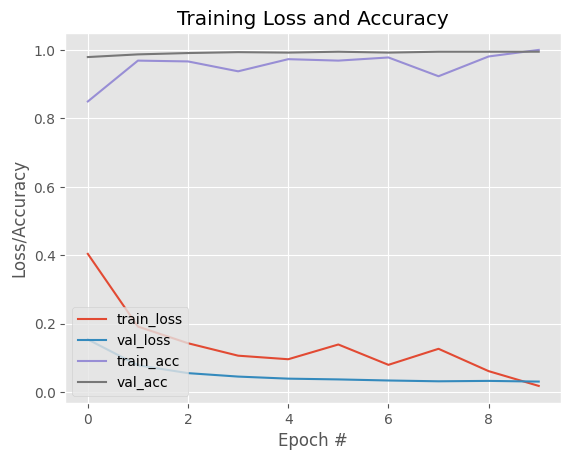

In [20]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

# Determine the correct number of epochs based on the minimum length of history logs
epochs = min(len(H.history["loss"]), len(H.history["val_loss"]))

plt.plot(np.arange(0, epochs), H.history["loss"][:epochs], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"][:epochs], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"][:epochs], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"][:epochs], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
